## Train SRU model with embedding-cnn-100-v-0-2-0

Hope it will work...

### Installing SRU with v3.0.0

In [1]:
!pip install sru==3.0.0.dev6

### Importing Necessary Libraries

In [2]:
import logging
import os

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sru import SRU
from torch.nn import CrossEntropyLoss
from torch.nn import Module, Dropout, Linear
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import gc

gc.collect()

40

### Set the Device to CUDA

In [3]:
# Set the device to use (e.g., 'cpu', 'cuda', 'mps')
device = torch.device("mps" if torch.backends.mps.is_available() else
                      ("cuda" if torch.cuda.is_available() else "cpu"))

# Select Device According to Availability
print("Device selected:", device)

# If the device is CUDA, print the device capability
if device.type == "cuda":
    os.system("nvidia-smi")
    print()
    print("Device type:", device.type)
    print("Capability:", torch.cuda.get_device_capability(device))
else:
    print("Device capabilities are limited on MPSs and CPUs.")

gc.collect()

Device selected: cuda
Tue Mar 19 03:24:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+---

0

### Read the file, Validate and View Shape

In [4]:
file_embeddings = np.load('/kaggle/input/train_embeddings.npy')
file_labels = np.load('/kaggle/input/train_labels.npy')

# Check if the embeddings and labels are of the same length
if len(file_embeddings) != len(file_labels):
    raise ValueError("The length of the embeddings and labels should be the same")

# check if the embedding is a 3D array
if len(file_embeddings.shape) != 3:
    raise ValueError(f"The embeddings should be a 4D array [instances, windows, frames, features]."
                     f" Found {len(file_embeddings.shape)}D instead.")

print("Files Loaded Successfully")
print("Video Embeddings Shape:", file_embeddings.shape)
print("Video Labels Shape:", file_labels.shape)
gc.collect()

Files Loaded Successfully
Video Embeddings Shape: (9150, 100, 2048)
Video Labels Shape: (9150,)


22

### Train Test Split, Convert to torch.tensor and View Shape

In [5]:
test_size = 0.2


# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(file_embeddings,
                                                    file_labels,
                                                    test_size=test_size,
                                                    random_state=42)


# convert to tensor
train_embeddings = torch.from_numpy(x_train).to(device)
# train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], -1)
train_labels = torch.from_numpy(y_train).to(device)
test_embeddings = torch.from_numpy(x_test).to(device)
# test_embeddings = test_embeddings.reshape(test_embeddings.shape[0], -1)
test_labels = torch.from_numpy(y_test).to(device)

print('Shape of Train Embeddings:', train_embeddings.shape)
print('Shape of Train Labels:', train_labels.shape)
print('Shape of Test Embeddings:', test_embeddings.shape)
print('Shape of Test Labels:', test_labels.shape)

gc.collect()

Shape of Train Embeddings: torch.Size([7320, 100, 2048])
Shape of Train Labels: torch.Size([7320])
Shape of Test Embeddings: torch.Size([1830, 100, 2048])
Shape of Test Labels: torch.Size([1830])


0

### Delete all unnecessary variables

This is important because the embeddings are huge in size and the variables take around 15.1 GiB / 29 GiB. **After running the cell it will drop down to 1.2 GiB**

In [6]:
del file_embeddings
del file_labels
del x_train
del x_test
del y_train
del y_test
gc.collect()

0

### Reshaping the tensors

To fit in SRU model we need to reshape the tensors. Currently, they are in 3D shape, `(videos, frames, features)`. But SRU expects the tensor in different format.

SRU expects a 3D tensor shaped like `(sequence_length, batch_size, input_size)`, which for our case, `sequence_length` would be `frames`, `batch_size` would be `videos` and `input_size` would be `features`. So, we need to convert from shape `(7320, 100, 2048)` to shape `(100, 7320, 2048)`

Now we need to reshape the labels as well

In [7]:



# batch_size = 8

# # Create TensorDataset
# train_data = TensorDataset(train_embeddings, train_labels)
# test_data = TensorDataset(test_embeddings, test_labels)

# """
# Each train data has (2, 100 , 2048)
# len(train_data) -> videos -
# train_data[i][0] -> Video embed,  Shape: (100, 2048)
# train_data[i][1] -> Label, Shape: (1, )

# train_data[i][0][0] -> First (0th) frame Features, Shape: (2048, )
# Same goes for test data
# """

# ###########################

# train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# """
# Length of loader = train data // batch size = 7320 // 8 = 915
# Inside of each (915) element in data_loader...........

# len(i) -> 2 Which means each element has 2 sub element
# We can access i[0] and i[1].
# len(i[0]) = 8 and len(i[0]) = 8


# So both element has 8 elements. First one is 8 video, secons one is 8 labels corresponding to the videos.\

# For example,

#             for i in train_loader:
#             print(i[0])
#             break
    
# prints: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

# so The first element contains 8 videos. 
# """

In [8]:
batch_size = 8

# Create TensorDataset
train_data = TensorDataset(train_embeddings, train_labels)
test_data = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Train loader length is = 915 which means 915 * batch size 8 = 7320 data points, which are actually videos.
# same goes for test loader
# our sequence length is then 204800 which is the total features

In [9]:
class SRUModel(Module):
    def __init__(self, input_size, hidden_size, **kwargs):
        super(SRUModel, self).__init__()
        # Main SRU layer
        self.sru_layers = SRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=kwargs.get('num_layers', 2),
            dropout=kwargs.get('dropout_prob', 0.0),
            bidirectional=kwargs.get('bidirectional', False),
            layer_norm=kwargs.get('layer_norm', False),
            highway_bias=kwargs.get('highway_bias', 0.0),
            rescale=kwargs.get('rescale', True),
            nn_rnn_compatible_return=kwargs.get('nn_rnn_compatible_return', False),
            proj_input_to_hidden_first=kwargs.get('proj_input_to_hidden_first', False),
            amp_recurrence_fp16=kwargs.get('amp_recurrence_fp16', False),
            normalize_after=kwargs.get('normalize_after', False),
        ).to(device)
        # Dropout layer
        self.dropout = Dropout(kwargs.get('dropout_layer_prob', 0.2)).to(device)
        # Linear layer (Fully connected layer)
        self.linear = Linear(
            in_features=hidden_size * 2 if kwargs.get('bidirectional', False) else hidden_size,
            out_features=kwargs.get('num_classes', 2)
        ).to(device)
        # L2 regularization
        self.l2_reg_lambda = kwargs.get('l2_reg_lambda', 1e-5)

    def forward(self, x):
        output_states, _ = self.sru_layers(x)
        output = self.linear(self.dropout(output_states[-1]))
        return output

    def l2_regularization(self):
        l2_reg = torch.tensor(0., device=device)
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        return self.l2_reg_lambda * l2_reg


model = SRUModel(2048, 1024)
model = model.to(device)
model

SRUModel(
  (sru_layers): SRU(
    (rnn_lst): ModuleList(
      (0): SRUCell(2048, 1024, rescale=True,
        transform_module=Linear(in_features=2048, out_features=4096, bias=False)
      )
      (1): SRUCell(1024, 1024, rescale=True,
        transform_module=Linear(in_features=1024, out_features=3072, bias=False)
      )
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=1024, out_features=2, bias=True)
)

In [10]:
# Define your loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [11]:
epochs = 50

total_correct_all_epochs = 0
total_samples_all_epochs = 0

# Setup logging
logging.basicConfig(filename='training.log', level=logging.INFO)

for epoch in range(epochs):
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    # Create tqdm progress bar for training loader
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", total=len(train_loader))

    for i, (videos, labels) in progress_bar:
        videos = videos.permute(1, 0, 2)
        # Forward pass
        outputs = model(videos)
        labels = labels.long()  # Convert labels to Long type
        loss = criterion(outputs, labels) + model.l2_regularization()  # calculates loss
        total_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy per batch
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        batch_accuracy = 100 * total_correct / total_samples

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), accuracy=batch_accuracy)
        
        # Update overall accuracy counters
        total_correct_all_epochs += total_correct
        total_samples_all_epochs += total_samples

    # Log epoch statistics
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100 * total_correct / total_samples
    logging.info(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')

# Close logging
logging.shutdown()

overall_accuracy = 100 * total_correct_all_epochs / total_samples_all_epochs
print(f'Average Train Accuracy of the model on the train videos: {overall_accuracy}%')

Epoch 1/50: 100%|██████████| 915/915 [00:11<00:00, 79.51it/s, accuracy=50.2, loss=0.665]


Epoch [1/50], Loss: 0.6976477209336119, Accuracy: 50.177595628415304%


Epoch 2/50: 100%|██████████| 915/915 [00:10<00:00, 85.43it/s, accuracy=53.1, loss=0.728]


Epoch [2/50], Loss: 0.6913663995721953, Accuracy: 53.14207650273224%


Epoch 3/50: 100%|██████████| 915/915 [00:10<00:00, 84.53it/s, accuracy=58.5, loss=0.689]


Epoch [3/50], Loss: 0.6725147883097331, Accuracy: 58.45628415300546%


Epoch 4/50: 100%|██████████| 915/915 [00:10<00:00, 84.46it/s, accuracy=61.8, loss=0.675]


Epoch [4/50], Loss: 0.6545781615979033, Accuracy: 61.81693989071038%


Epoch 5/50: 100%|██████████| 915/915 [00:10<00:00, 84.78it/s, accuracy=63.2, loss=0.656]


Epoch [5/50], Loss: 0.6492501698556493, Accuracy: 63.23770491803279%


Epoch 6/50: 100%|██████████| 915/915 [00:10<00:00, 84.96it/s, accuracy=65.1, loss=0.716]


Epoch [6/50], Loss: 0.6367327845813147, Accuracy: 65.10928961748634%


Epoch 7/50: 100%|██████████| 915/915 [00:10<00:00, 85.28it/s, accuracy=65.8, loss=0.424]


Epoch [7/50], Loss: 0.6311279763289488, Accuracy: 65.80601092896175%


Epoch 8/50: 100%|██████████| 915/915 [00:10<00:00, 85.11it/s, accuracy=67, loss=0.589]


Epoch [8/50], Loss: 0.6141859832845751, Accuracy: 67.00819672131148%


Epoch 9/50: 100%|██████████| 915/915 [00:10<00:00, 84.55it/s, accuracy=67.6, loss=0.802]


Epoch [9/50], Loss: 0.6052667210336591, Accuracy: 67.63661202185793%


Epoch 10/50: 100%|██████████| 915/915 [00:10<00:00, 85.18it/s, accuracy=68.2, loss=0.707]


Epoch [10/50], Loss: 0.5993110478250055, Accuracy: 68.23770491803279%


Epoch 11/50: 100%|██████████| 915/915 [00:10<00:00, 84.71it/s, accuracy=69.3, loss=0.679]


Epoch [11/50], Loss: 0.5848013615510502, Accuracy: 69.34426229508196%


Epoch 12/50: 100%|██████████| 915/915 [00:10<00:00, 84.93it/s, accuracy=70.5, loss=0.436]


Epoch [12/50], Loss: 0.5804564490181501, Accuracy: 70.5464480874317%


Epoch 13/50: 100%|██████████| 915/915 [00:10<00:00, 85.05it/s, accuracy=70.3, loss=0.301]


Epoch [13/50], Loss: 0.5770984095790999, Accuracy: 70.27322404371584%


Epoch 14/50: 100%|██████████| 915/915 [00:10<00:00, 84.86it/s, accuracy=71.5, loss=0.554]


Epoch [14/50], Loss: 0.5634622885962653, Accuracy: 71.53005464480874%


Epoch 15/50: 100%|██████████| 915/915 [00:10<00:00, 84.82it/s, accuracy=70.5, loss=0.356]


Epoch [15/50], Loss: 0.5629519679588698, Accuracy: 70.5327868852459%


Epoch 16/50: 100%|██████████| 915/915 [00:10<00:00, 85.03it/s, accuracy=72, loss=0.555]


Epoch [16/50], Loss: 0.5548182504261777, Accuracy: 72.00819672131148%


Epoch 17/50: 100%|██████████| 915/915 [00:10<00:00, 84.55it/s, accuracy=72.6, loss=0.317]


Epoch [17/50], Loss: 0.5468907707945897, Accuracy: 72.59562841530055%


Epoch 18/50: 100%|██████████| 915/915 [00:10<00:00, 84.91it/s, accuracy=72.3, loss=0.319]


Epoch [18/50], Loss: 0.5527339308965401, Accuracy: 72.28142076502732%


Epoch 19/50: 100%|██████████| 915/915 [00:10<00:00, 84.94it/s, accuracy=73.1, loss=0.565]


Epoch [19/50], Loss: 0.5458271659137122, Accuracy: 73.06010928961749%


Epoch 20/50: 100%|██████████| 915/915 [00:10<00:00, 84.62it/s, accuracy=73.9, loss=0.542]


Epoch [20/50], Loss: 0.5362699206898122, Accuracy: 73.9207650273224%


Epoch 21/50: 100%|██████████| 915/915 [00:10<00:00, 84.98it/s, accuracy=74, loss=0.58]


Epoch [21/50], Loss: 0.5273212825502854, Accuracy: 73.96174863387978%


Epoch 22/50: 100%|██████████| 915/915 [00:10<00:00, 84.99it/s, accuracy=74.2, loss=0.518]


Epoch [22/50], Loss: 0.5353068335948746, Accuracy: 74.23497267759562%


Epoch 23/50: 100%|██████████| 915/915 [00:10<00:00, 84.77it/s, accuracy=74.8, loss=0.69]


Epoch [23/50], Loss: 0.5211315019371731, Accuracy: 74.84972677595628%


Epoch 24/50: 100%|██████████| 915/915 [00:10<00:00, 84.95it/s, accuracy=74.7, loss=0.398]


Epoch [24/50], Loss: 0.5211320091954997, Accuracy: 74.68579234972678%


Epoch 25/50: 100%|██████████| 915/915 [00:10<00:00, 84.82it/s, accuracy=74.2, loss=0.268]


Epoch [25/50], Loss: 0.5256231592571149, Accuracy: 74.18032786885246%


Epoch 26/50: 100%|██████████| 915/915 [00:10<00:00, 84.41it/s, accuracy=74.8, loss=0.547]


Epoch [26/50], Loss: 0.5213447762154491, Accuracy: 74.79508196721312%


Epoch 27/50: 100%|██████████| 915/915 [00:10<00:00, 84.68it/s, accuracy=75.4, loss=0.866]


Epoch [27/50], Loss: 0.5150234800381739, Accuracy: 75.3688524590164%


Epoch 28/50: 100%|██████████| 915/915 [00:10<00:00, 84.65it/s, accuracy=75, loss=0.25]


Epoch [28/50], Loss: 0.516894208065799, Accuracy: 74.98633879781421%


Epoch 29/50: 100%|██████████| 915/915 [00:10<00:00, 84.47it/s, accuracy=76.1, loss=0.557]


Epoch [29/50], Loss: 0.5053726914231894, Accuracy: 76.0792349726776%


Epoch 30/50: 100%|██████████| 915/915 [00:10<00:00, 84.78it/s, accuracy=75.1, loss=0.583]


Epoch [30/50], Loss: 0.5097295846118302, Accuracy: 75.05464480874316%


Epoch 31/50: 100%|██████████| 915/915 [00:10<00:00, 84.76it/s, accuracy=76.2, loss=0.551]


Epoch [31/50], Loss: 0.49893151033934346, Accuracy: 76.20218579234972%


Epoch 32/50: 100%|██████████| 915/915 [00:10<00:00, 84.37it/s, accuracy=75.7, loss=0.212]


Epoch [32/50], Loss: 0.5098697439568942, Accuracy: 75.65573770491804%


Epoch 33/50: 100%|██████████| 915/915 [00:10<00:00, 83.83it/s, accuracy=76.2, loss=0.594]


Epoch [33/50], Loss: 0.4997076505683159, Accuracy: 76.2431693989071%


Epoch 34/50: 100%|██████████| 915/915 [00:11<00:00, 82.87it/s, accuracy=76.2, loss=0.285]


Epoch [34/50], Loss: 0.5016405470302847, Accuracy: 76.22950819672131%


Epoch 35/50: 100%|██████████| 915/915 [00:10<00:00, 83.79it/s, accuracy=75.8, loss=0.666]


Epoch [35/50], Loss: 0.5014325002340672, Accuracy: 75.76502732240438%


Epoch 36/50: 100%|██████████| 915/915 [00:10<00:00, 84.62it/s, accuracy=76.7, loss=0.524]


Epoch [36/50], Loss: 0.4911074839735943, Accuracy: 76.69398907103825%


Epoch 37/50: 100%|██████████| 915/915 [00:10<00:00, 84.53it/s, accuracy=77.1, loss=0.277]


Epoch [37/50], Loss: 0.48270536734432473, Accuracy: 77.14480874316939%


Epoch 38/50: 100%|██████████| 915/915 [00:10<00:00, 84.67it/s, accuracy=76.5, loss=0.385]


Epoch [38/50], Loss: 0.49129535977224836, Accuracy: 76.48907103825137%


Epoch 39/50: 100%|██████████| 915/915 [00:10<00:00, 84.49it/s, accuracy=76.6, loss=0.322]


Epoch [39/50], Loss: 0.4880912799978517, Accuracy: 76.63934426229508%


Epoch 40/50: 100%|██████████| 915/915 [00:10<00:00, 84.47it/s, accuracy=77.1, loss=0.971]


Epoch [40/50], Loss: 0.4858414850925487, Accuracy: 77.14480874316939%


Epoch 41/50: 100%|██████████| 915/915 [00:10<00:00, 84.93it/s, accuracy=77.3, loss=0.336]


Epoch [41/50], Loss: 0.48427203256901497, Accuracy: 77.3224043715847%


Epoch 42/50: 100%|██████████| 915/915 [00:10<00:00, 84.45it/s, accuracy=77.2, loss=0.518]


Epoch [42/50], Loss: 0.4847014718042697, Accuracy: 77.1584699453552%


Epoch 43/50: 100%|██████████| 915/915 [00:10<00:00, 84.51it/s, accuracy=78.5, loss=0.297]


Epoch [43/50], Loss: 0.4669286574496598, Accuracy: 78.46994535519126%


Epoch 44/50: 100%|██████████| 915/915 [00:10<00:00, 84.92it/s, accuracy=76.9, loss=0.18]


Epoch [44/50], Loss: 0.48701227435974476, Accuracy: 76.91256830601093%


Epoch 45/50: 100%|██████████| 915/915 [00:10<00:00, 84.18it/s, accuracy=78, loss=0.263]


Epoch [45/50], Loss: 0.4710893685374755, Accuracy: 77.96448087431693%


Epoch 46/50: 100%|██████████| 915/915 [00:10<00:00, 84.30it/s, accuracy=77.7, loss=0.447]


Epoch [46/50], Loss: 0.4823911969290405, Accuracy: 77.6639344262295%


Epoch 47/50: 100%|██████████| 915/915 [00:10<00:00, 84.70it/s, accuracy=78.2, loss=1.14]


Epoch [47/50], Loss: 0.47517914466682026, Accuracy: 78.15573770491804%


Epoch 48/50: 100%|██████████| 915/915 [00:10<00:00, 84.46it/s, accuracy=78.6, loss=0.366]


Epoch [48/50], Loss: 0.4693522439546924, Accuracy: 78.64754098360656%


Epoch 49/50: 100%|██████████| 915/915 [00:10<00:00, 84.28it/s, accuracy=79.2, loss=0.415]


Epoch [49/50], Loss: 0.45845063125175206, Accuracy: 79.19398907103825%


Epoch 50/50: 100%|██████████| 915/915 [00:10<00:00, 84.57it/s, accuracy=79.1, loss=0.864]


Epoch [50/50], Loss: 0.45705055347312995, Accuracy: 79.09836065573771%
Average Train Accuracy of the model on the train videos: 72.53430632113967%


In [12]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for videos, labels in test_loader:
        videos = videos.permute(1, 0, 2)
        outputs = model(videos)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print test accuracy per test

    print(f'Test Accuracy of the model on the test videos: {100 * correct / total}%')

Test Accuracy of the model on the test videos: 75.68306010928961%


Confusion Matrix:
[[875  40]
 [405 510]]


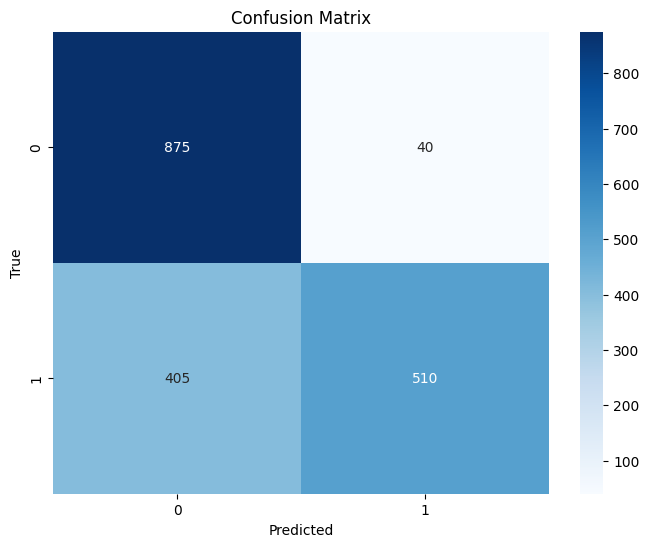

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Set model to evaluation mode
model.eval()

# Initialize variables for predictions and ground truth labels
all_predictions = []
all_labels = []

# Iterate through the test dataset
for videos, labels in test_loader:
#     videos = videos.unsqueeze(0)
    videos = videos.permute(1, 0, 2)
    # Forward pass
    outputs = model(videos)
    # Predictions
    _, predicted = torch.max(outputs.data, 1)
    # Append predictions and labels to the lists
    all_predictions.extend(predicted.tolist())
    all_labels.extend(labels.tolist())

# Convert predictions and labels lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

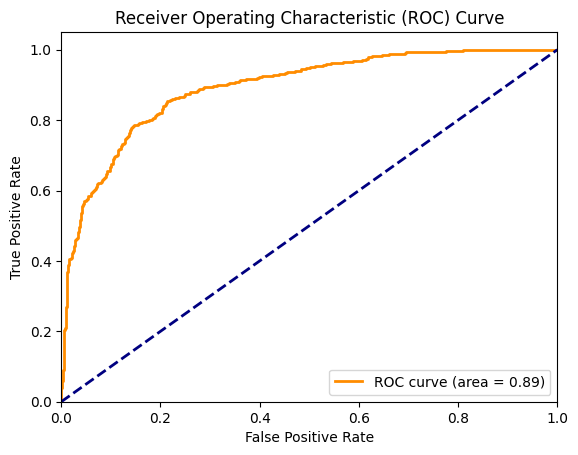

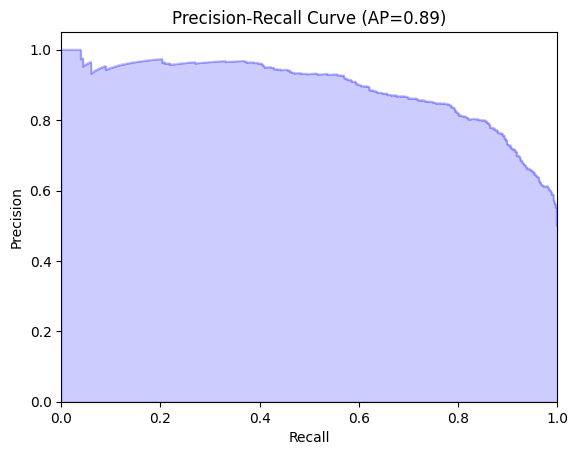

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Initialize variables for predictions and ground truth labels
all_probs = []
all_labels = []

# Iterate through the test dataset
for videos, labels in test_loader:
#     videos = videos.unsqueeze(0)
    videos = videos.permute(1, 0, 2)
    # Forward pass
    outputs = model(videos)
    # Get probabilities
    probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
    # Append probabilities and labels to the lists
    all_probs.extend(probs.tolist())
    all_labels.extend(labels.tolist())

# Convert probabilities and labels lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# AUC ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
average_precision = average_precision_score(all_labels, all_probs)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
plt.show()